# 1. 시나리오

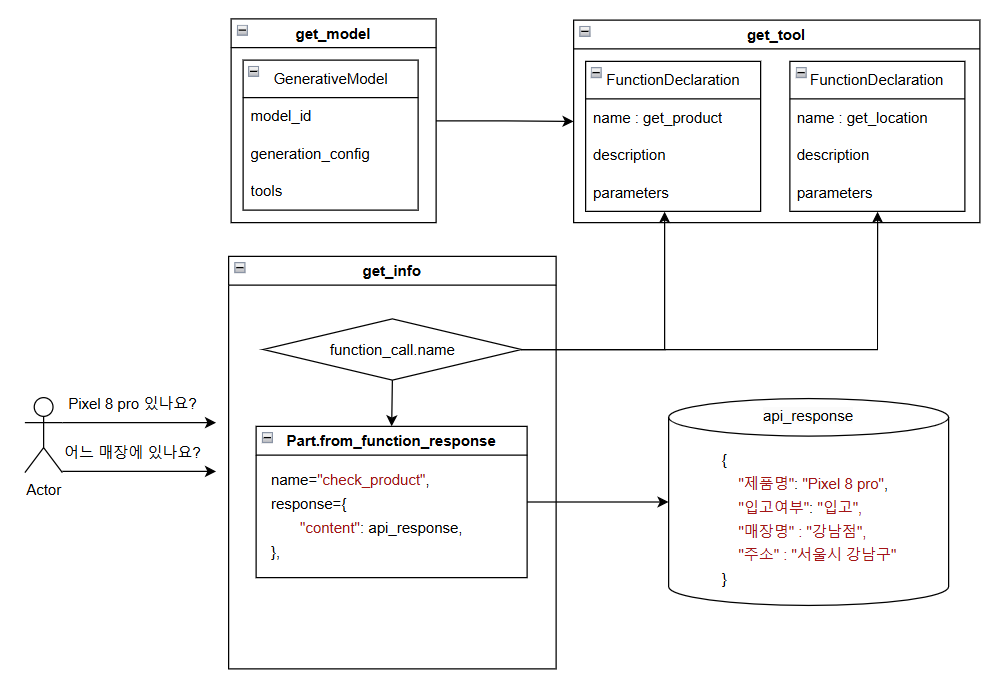

# 2. 초기화

In [2]:
import vertexai

from vertexai.generative_models import(
    GenerativeModel,
    FunctionDeclaration,
    Part,
    Tool
)

In [3]:
PROJECT_ID=!gcloud config get-value core/project
PROJECT_ID=PROJECT_ID[0]
LOCATION='us-east1'

# 3. 모델 및 tool 함수 제작

In [4]:
def get_model(project_id, location, model_id, tools):
  vertexai.init(project=project_id, location=location)
  return GenerativeModel(
      model_id,
      generation_config={"temperature":0},
      tools=[tools]
  )

def get_tool():
  get_product = FunctionDeclaration(
      name="get_product",
      description="제품의 이름을 얻을 수 있다.",
      parameters={
          "type": "object",
          "properties":{
              "product_name":{
                  "type": "string",
                  "description": "제품의 이름"
              }
          }
      }
  )
  get_location=FunctionDeclaration(
      name="get_location",
      description="제품을 판매하는 매장 위치를 얻을 수 있다.",
      parameters={
          "type": "object",
          "properties":{
              "store_location":{
                  "type": "string",
                  "description": "매장의 위치"
              }
          }
      }
  )

  return Tool(function_declarations=[get_product, get_location])

# 4. 모델 초기화

In [10]:
model_name="gemini-1.5-pro"

tools=get_tool()
model = get_model(PROJECT_ID, LOCATION, model_name, tools)

chat = model.start_chat()

# 5. 정보 확인

In [11]:
def get_info(chat, response):
  part = response.candidates[0].content.parts[0]

  if part.function_call.name == "get_product":
    product_name = part.function_call.args["product_name"]
    print(product_name)
    api_response = {"제품명": "겔럭시 s24", "입고여부": "입고"}
  elif part.function_call.name == "get_location":
    store_location = part.function_call.args["store_location"]
    print(store_location)
    api_response = {"매장명": "강남점", "주소": "서울시 강남구"}

  response = chat.send_message(
      Part.from_function_response(
          name = "get_product_info",
          response={
              "content": api_response
          }
      )
  )

  return response

In [12]:
prompt = "겔럭시 s24 있나요?"
response = chat.send_message(prompt)
response = get_info(chat, response)
print(response.text)

겔럭시 s24
네, 겔럭시 s24 입고되어 있습니다. 



In [13]:
prompt = "어느 매장에 있나요?"
response = chat.send_message(prompt)
response = get_info(chat, response)
print(response.text)

갤럭시 s24
강남점에 있습니다. 주소는 서울시 강남구 입니다. 



# 6. 함수 최적화

In [35]:
def get_info(chat, response, api_response):
  part = response.candidates[0].content.parts[0]

  # if part.function_call.name == "get_product":
  #   product_name = part.function_call.args["product_name"]
  #   print(product_name)
  #   api_response = {"제품명": "겔럭시 s24", "입고여부": "입고"}
  # elif part.function_call.name == "get_location":
  #   store_location = part.function_call.args["store_location"]
  #   print(store_location)
  #   api_response = {"매장명": "강남점", "주소": "서울시 강남구"}
  response = chat.send_message(
    Part.from_function_response(
        name = part.function_call.name,
        response={
            "content": api_response
        }
    )
  )

  return response

In [36]:
prompt = "아이폰 있나요?"
api_response = [
    {"제품명": "겔럭시 s24", "입고여부": "입고", "매장명": "강남점", "주소": "서울시 강남구"},
    {"제품명": "아이폰 16", "입고여부": "입고", "매장명": "강동점", "주소": "서울시 강동구"},
    {"제품명": "pixel 8 pro", "입고여부": "입고예정", "매장명": "강북점", "주소": "서울시 강북구"},
    {"제품명": "pixel 6", "입고여부": "제고없음", "매장명": "강서점", "주소": "서울시 강서구"},
]
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

네, 아이폰 16 강동점에 입고되어 있습니다. 





In [37]:
prompt = "주소는 어떻게 되나요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

AttributeError: 'NoneType' object has no attribute 'name'

# 7. 예외처리

In [42]:
def get_info(chat, response, api_response):
  part = response.candidates[0].content.parts[0]

  print("==== part info ====")
  print(part)

  response = chat.send_message(
    Part.from_function_response(
        name = part.function_call.name,
        response={
            "content": api_response
        }
    )
  )

  return response

In [43]:
prompt = "아이폰 16 있나요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

==== part info ====
function_call {
  name: "get_product"
  args {
    fields {
      key: "product_name"
      value {
        string_value: "아이폰 16"
      }
    }
  }
}

네, 아이폰 16 강동점에 입고되어 있습니다. 







In [44]:
prompt = "주소는 어떻게 되나요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

==== part info ====
text: "서울시 강동구에 있습니다. \n\n\n\n\n\n\n"



AttributeError: 'NoneType' object has no attribute 'name'

In [50]:
def get_info(chat, response, api_response):
  part = response.candidates[0].content.parts[0]

  try:
    response = chat.send_message(
      Part.from_function_response(
          name = part.function_call.name,
          response={
              "content": api_response
          }
      )
    )
  except AttributeError:
    1

  return response

In [51]:
prompt = "스마트폰 있나요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

네, 스마트폰은 겔럭시 s24, 아이폰 16, pixel 8 pro, pixel 6 이 있습니다. 어떤 제품을 찾으시나요? 





In [52]:
prompt = "pixel 6를 구매하려고 하는데요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

pixel 6는 현재 품절입니다. 죄송합니다. 





In [53]:
prompt = "그럼 pixel 8 pro를 살 수 있을까요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

pixel 8 pro는 현재 강북점에 입고 예정입니다. 곧 매장에 확인해보세요. 







In [54]:
prompt = "매장을 가려면 어디로 가야 하나요?"
response = chat.send_message(prompt)
response = get_info(chat, response, api_response)
print(response.text)

서울시 강북구에 있습니다. 







